--- 🔬 Simulating Model-Level Optimization: Augmented Architecture ---

--- Simulation Summary ---
Prompt Length: 8192, Generation Length: 2048

Standard Transformer Memory:
  - KV Cache Size: 1.758 GB
  - Total VRAM:    4.758 GB (Baseline)

Augmented Architecture Memory:
  - Compressed Prompt Cache: 0.141 GB
  - Generation KV Cache:     0.352 GB
  - Total VRAM:              3.492 GB

✅ Augmented Architecture reduced TOTAL VRAM usage by 26.60%.

📊 Graph saved as 'architecture_alteration_simulation.png'


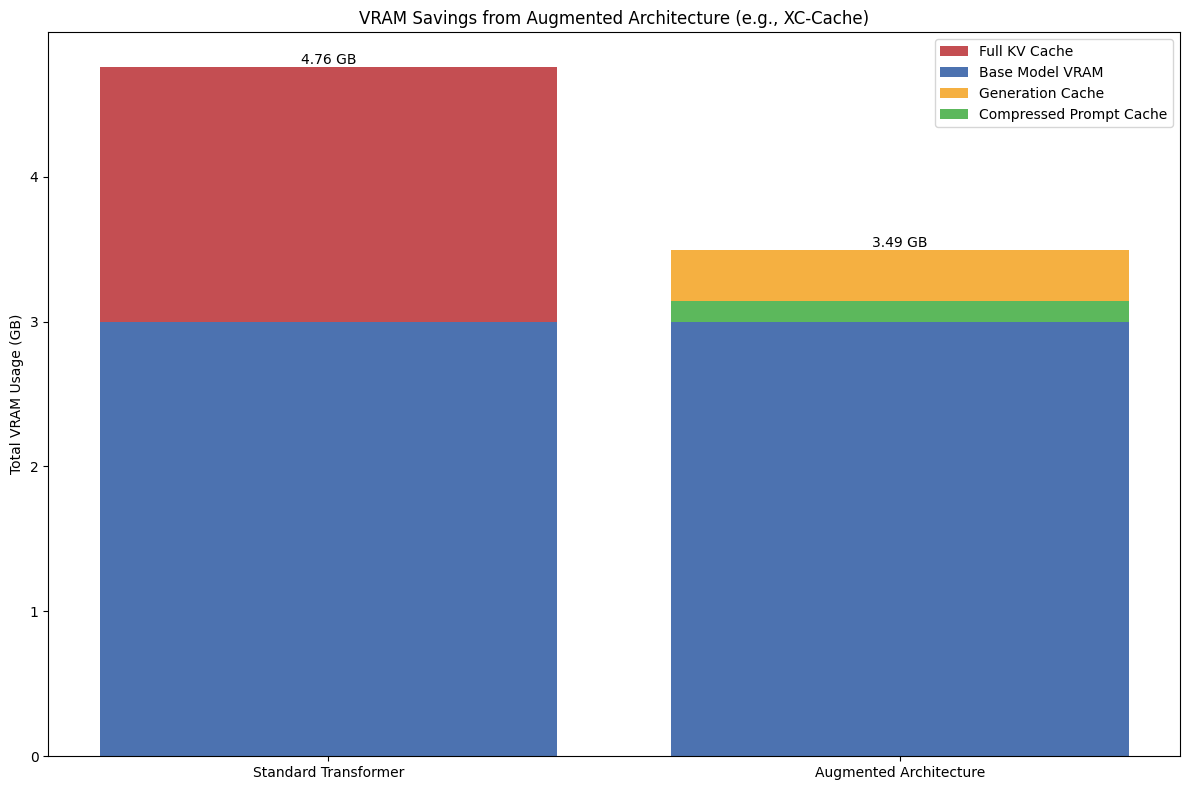

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
# We'll use parameters similar to gpt2-large for our calculation.
MODEL_CONFIG = {
    "num_layers": 36,
    "hidden_size": 1280,
    "num_query_heads": 20,
    "base_model_vram_gb": 3.0
}

# --- SIMULATION PARAMETERS ---
PROMPT_LENGTH = 8192      # A long initial prompt
GENERATION_LENGTH = 2048  # Number of tokens to generate
BATCH_SIZE = 1
BYTES_PER_ELEMENT = 2     # For FP16 precision

# The key parameter for our simulation: how much smaller is the compressed cache?
# A 10x compression is a reasonable assumption for this type of architecture.
PROMPT_CACHE_COMPRESSION_RATIO = 10.0

def calculate_kv_cache_vram(config, sequence_length):
    """
    Calculates the theoretical VRAM usage for a standard KV cache.
    """
    num_layers = config["num_layers"]
    hidden_size = config["hidden_size"]
    
    # Formula: Batch * SeqLen * Layers * 2 (for K,V) * HiddenSize * Bytes
    total_bytes = (
        BATCH_SIZE * sequence_length * num_layers * 2 * hidden_size * BYTES_PER_ELEMENT
    )
    
    # Convert bytes to gigabytes
    total_gb = total_bytes / (1024**3)
    return total_gb

def main():
    print("--- 🔬 Simulating Model-Level Optimization: Augmented Architecture ---")

    # --- 1. Calculate for a Standard Transformer (Baseline) ---
    total_sequence_length = PROMPT_LENGTH + GENERATION_LENGTH
    baseline_cache_vram = calculate_kv_cache_vram(MODEL_CONFIG, total_sequence_length)
    baseline_total_vram = MODEL_CONFIG["base_model_vram_gb"] + baseline_cache_vram

    # --- 2. Calculate for an Augmented Architecture (like XC-Cache) ---
    # a) Calculate the original, uncompressed size of the prompt's cache
    full_prompt_cache_vram = calculate_kv_cache_vram(MODEL_CONFIG, PROMPT_LENGTH)
    # b) Apply the compression ratio to get the small, fixed summary cache
    compressed_prompt_cache_vram = full_prompt_cache_vram / PROMPT_CACHE_COMPRESSION_RATIO
    # c) Calculate the cache needed for the *newly generated tokens only*
    generation_only_cache_vram = calculate_kv_cache_vram(MODEL_CONFIG, GENERATION_LENGTH)
    # d) The total cache is the small prompt summary + the new generation cache
    optimized_total_cache_vram = compressed_prompt_cache_vram + generation_only_cache_vram
    optimized_total_vram = MODEL_CONFIG["base_model_vram_gb"] + optimized_total_cache_vram
    
    # --- 3. Print Summary ---
    print("\n--- Simulation Summary ---")
    print(f"Prompt Length: {PROMPT_LENGTH}, Generation Length: {GENERATION_LENGTH}")
    print(f"\nStandard Transformer Memory:")
    print(f"  - KV Cache Size: {baseline_cache_vram:.3f} GB")
    print(f"  - Total VRAM:    {baseline_total_vram:.3f} GB (Baseline)")
    
    print(f"\nAugmented Architecture Memory:")
    print(f"  - Compressed Prompt Cache: {compressed_prompt_cache_vram:.3f} GB")
    print(f"  - Generation KV Cache:     {generation_only_cache_vram:.3f} GB")
    print(f"  - Total VRAM:              {optimized_total_vram:.3f} GB")
    
    savings_percent = (1 - optimized_total_vram / baseline_total_vram) * 100
    print(f"\n✅ Augmented Architecture reduced TOTAL VRAM usage by {savings_percent:.2f}%.")

    # --- 4. Plot the results using a stacked bar chart ---
    labels = ['Standard Transformer', 'Augmented Architecture']
    base_model_vram = MODEL_CONFIG["base_model_vram_gb"]

    # Data for stacking
    baseline_data = [base_model_vram, baseline_cache_vram]
    optimized_data = [base_model_vram, compressed_prompt_cache_vram, generation_only_cache_vram]

    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot baseline bar
    ax.bar(labels[0], baseline_data[1], bottom=baseline_data[0], color='#c44e52', label='Full KV Cache')
    ax.bar(labels[0], baseline_data[0], color='#4c72b0', label='Base Model VRAM')

    # Plot optimized bar
    ax.bar(labels[1], optimized_data[2], bottom=optimized_data[0] + optimized_data[1], color='#f5b041', label='Generation Cache')
    ax.bar(labels[1], optimized_data[1], bottom=optimized_data[0], color='#5cb85c', label='Compressed Prompt Cache')
    ax.bar(labels[1], optimized_data[0], color='#4c72b0') # No label to avoid duplicates

    ax.set_ylabel('Total VRAM Usage (GB)')
    ax.set_title('VRAM Savings from Augmented Architecture (e.g., XC-Cache)')
    
    # Add text labels for total VRAM
    ax.text(labels[0], baseline_total_vram, f'{baseline_total_vram:.2f} GB', ha='center', va='bottom')
    ax.text(labels[1], optimized_total_vram, f'{optimized_total_vram:.2f} GB', ha='center', va='bottom')
    
    ax.legend()
    plt.tight_layout()
    plt.savefig("architecture_alteration_simulation.png")
    print("\n📊 Graph saved as 'architecture_alteration_simulation.png'")
    plt.show()


if __name__ == "__main__":
    main()